<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
pip install pygam

In [49]:
pip install graphviz

In [50]:
import pandas as pd        
from pygam import LogisticGAM
from matplotlib import pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_recall_curve) 
from sklearn.model_selection import train_test_split
#from sklearn.datasets import load_breast_cancer

In [52]:
df = pd.read_csv('spam.csv')
#df = df.assign(const=1)
#X = df[['make','address','all','3d','our','over','remove','internet','order','mail','receive','will','people','report','addresses','free','business','email','you','credit','your','font','a000','money','hp','hpl','george','n650','lab','labs','telnet','n857','data','n415','n85','technology','n1999','parts','pm','direct','cs','meeting','original','project','re','edu','table','conference','semicolon','parenthesis','bracket','admiration','dolar','cnum','averange','longest','total']] ## Predictors
X = df[['our','over','remove','internet','free','business','hpl','admiration','dolar','longest','total','hp','george','n1999','re','edu']] ## Predictors
y = df['spam']

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.66, random_state = 5)

df.sample(5)
df.describe()

,make,address,all,3d,our,over,remove,internet,order,mail,receive,will,people,report,addresses,free,business,email,you,credit,your,font,a000,money,hp,hpl,george,n650,lab,labs,telnet,n857,data,n415,n85,technology,n1999,parts,pm,direct,cs,meeting,original,project,re,edu,table,conference,semicolon,parenthesis,bracket,admiration,dolar,cnum,averange,longest,total,spam
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,0.059824,0.541702,0.093930,0.058626,0.049205,0.248848,0.142586,0.184745,1.662100,0.085577,0.809761,0.121202,0.101645,0.094269,0.549504,0.265384,0.767305,0.124845,0.098915,0.102852,0.064753,0.047048,0.097229,0.047835,0.105412,0.097477,0.136953,0.013201,0.078629,0.064834,0.043667,0.132339,0.046099,0.079196,0.301224,0.179824,0.005444,0.031869,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,0.201545,0.861698,0.301036,0.335184,0.258843,0.825792,0.444055,0.531122,1.775481,0.509767,1.200810,1.025756,0.350286,0.442636,1.671349,0.886955,3.367292,0.538576,0.593327,0.456682,0.403393,0.328559,0.555907,0.329445,0.532260,0.402623,0.423451,0.220651,0.434672,0.349916,0.361205,0.766819,0.223812,0.621976,1.011687,0.911119,0.076274,0.285735,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.310000,0.000000,0.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,0.000000,0.800000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,2.640000,0.000000,1.270000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [54]:
#Fit a model with the default parameters
gam = LogisticGAM().fit(X_train, y_train)

In [56]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     46.7347
Link Function:                        LogitLink Log Likelihood:                                  -262.1451
Number of Samples:                         1564 AIC:                                              617.7595
                                                AICc:                                             620.8301
                                                UBRE:                                               2.4189
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.7484
Feature Function                  Lam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [57]:
gam.accuracy(X_test, y_test)

0.925584458347053

In [58]:
#compute confussion matrix 
confussion_matrix = confusion_matrix(y_test, gam.predict(X_test))
confussion_matrix

array([[1750,   75],
       [ 151, 1061]])

In [ ]:
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, len(X_test))
titles = X_test.columns.values.tolist()
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i])
    if i == 0:
        ax.set_ylim(-30,30)
        ax.set_title(titles[i])
plt.show()

## Árboles de decisión

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


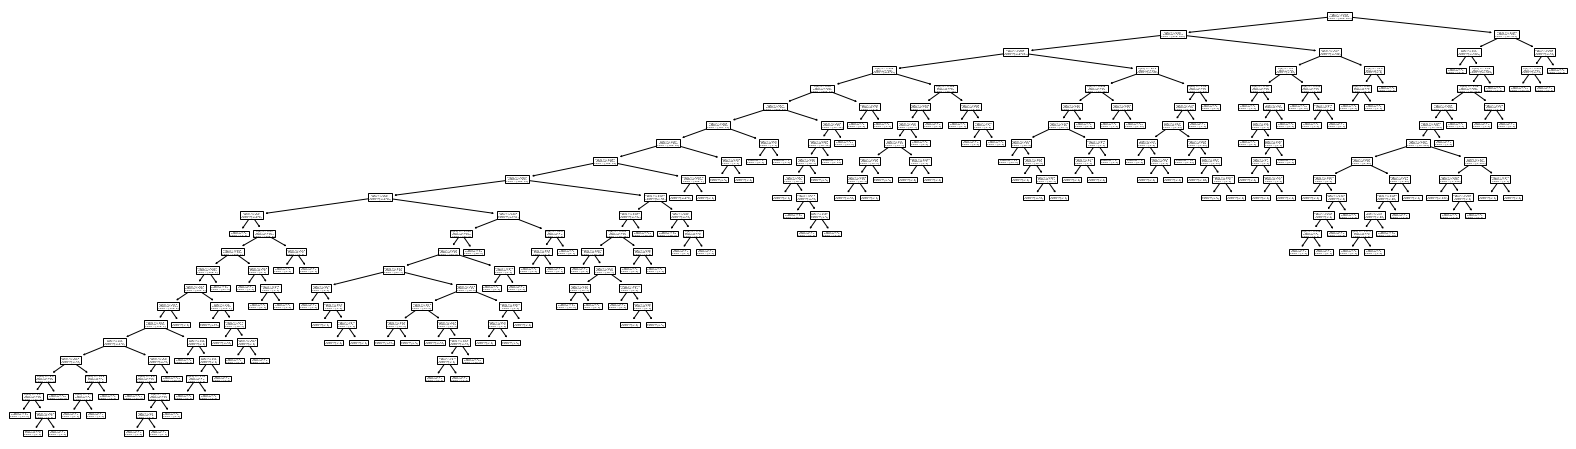

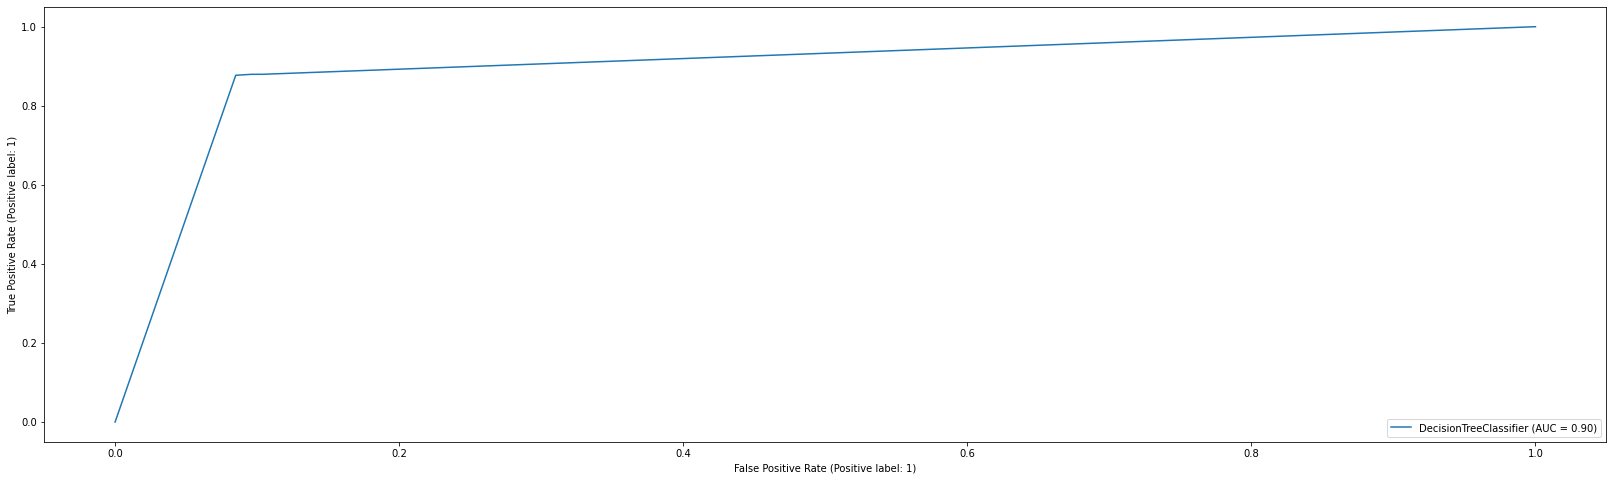

In [43]:
from sklearn import datasets, metrics, model_selection, svm
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
tree.plot_tree(clf)
metrics.plot_roc_curve(clf, X_test, y_test) 
plt.show()

In [33]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("spam") 

'spam.pdf'

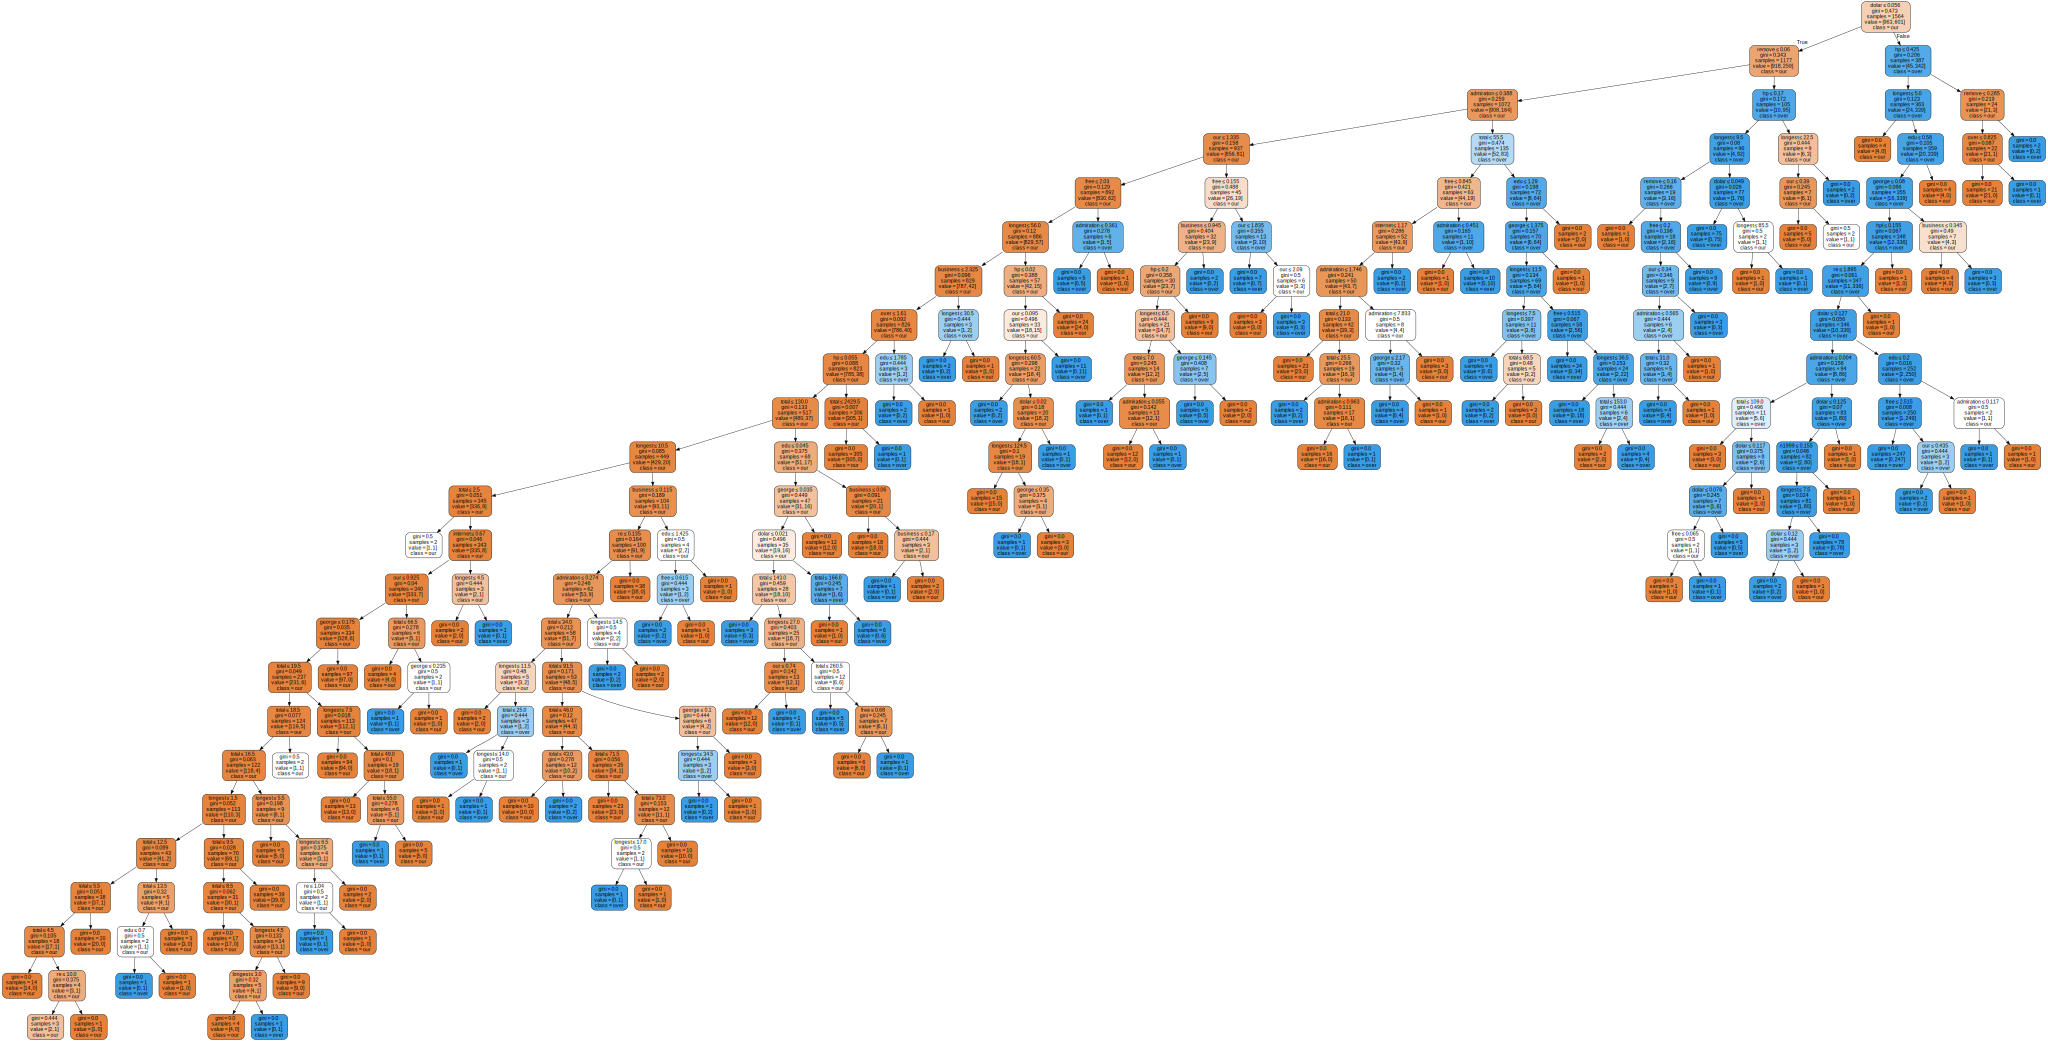

In [39]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X_test.columns.values.tolist(),
                                class_names=X_test.columns.values.tolist(),
                                filled=True, 
                                rounded=True, 
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [41]:

#compute confussion matrix 
confussion_matrix = confusion_matrix(y_test, clf.predict(X_test))
confussion_matrix

array([[1661,  164],
       [ 149, 1063]])

[A Tour of pyGAM](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html)

[A example of pyGAM](https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f)

[documentación pyGAM](https://pygam.readthedocs.io/en/latest/)

[pyGAM : Getting Started with Generalized Additive Models in Python](https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f)

[Building interpretable models with Generalized additive models in Python](https://medium.com/just-another-data-scientist/building-interpretable-models-with-generalized-additive-models-in-python-c4404eaf5515)